# Assignment 2 - Fact checking

This notebook propose a solution to particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In [1]:
import os
import requests
import zipfile
import glob
from urllib import request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import re
from functools import reduce
from tqdm import tqdm

import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## 1. Dataset preparation

For this experiment, the [FEVER dataset](https://fever.ai) dataset is used. The dataset is about facts taken from Wikipedia documents that have to be verified.

### 1.1 Dataset prepartion
Since the original datased require a significat effort to be prepared (download Wikipedia documents, replace reported evidence IDs with the corresponding text ...), an already pre-processed version of the dataset is used.

In [2]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

In [3]:
def read_data(data_path):
    """
    Reads the data from the data directory.
    
    Parameters
    ----------
    Path to the data directory.

    Returns
    -------
    A tuple of three pandas dataframes.
    """
    train_path = os.path.join(data_path, 'train_pairs.csv')
    val_path = os.path.join(data_path, 'val_pairs.csv')
    test_path = os.path.join(data_path, 'test_pairs.csv')

    train_df = pd.read_csv(train_path, index_col=0)
    val_df = pd.read_csv(val_path, index_col=0)
    test_df = pd.read_csv(test_path, index_col=0)

    return train_df, val_df, test_df

train_df, val_df, test_df = read_data('dataset')

### 1.2 Dataset analysis
Let's conduct some analysis on the dataset to understand the distribution of the labels and which are the most frequent non-alphanumeric characters that can be removed during preprocessing.

In [4]:
train_df.head()

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


It is immediately observable that the evidences contain a very raw text, where at beginning there is always a number followed by `\t` and at the end there is a list of keywords unuseful for the fact checking task.
Morover the rounded brackerts are representes as `-LRB` and `-RRB` and the squared bracked (`-LSB-` and `-RSB-`) usually contain the pronunciation or other worthless text.

In [6]:
# print an evidence
text = train_df['Evidence'].iloc[78]
text

'0\tLeBron Raymone James -LRB- -LSB- ləˈbrɒn -RSB- born December 30 , 1984 -RRB- is an American professional basketball player for the Cleveland Cavaliers of the National Basketball Association -LRB- NBA -RRB- .\tNBA\tNational Basketball Association\tCleveland Cavaliers\tCleveland Cavaliers\tbasketball\tbasketball\tNational Basketball Association\tNational Basketball Association\tCleveland\t2006–07 Cleveland Cavaliers season'

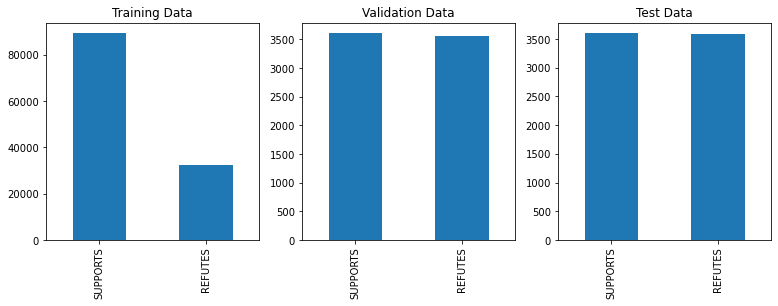

In [7]:
# plot the distribution of the labels
fig = plt.figure(figsize=(13, 4))
fig.add_subplot(131)
ax1 = train_df['Label'].value_counts().plot(kind='bar')
ax1.set_title('Training Data')
fig.add_subplot(132)
ax2 = val_df['Label'].value_counts().plot(kind='bar')
ax2.set_title('Validation Data')
fig.add_subplot(133)
ax3 = test_df['Label'].value_counts().plot(kind='bar')
ax3.set_title('Test Data')
plt.show()

In [8]:
# analyze the claim and evidence text non-alpha and non-numeric to understand what kind of preprocessing is needed
claim_words = [word for sentence in train_df['Claim'] for word in nltk.word_tokenize(sentence) if not word.isalpha() and not word.isnumeric()]
evidence_words = [word for sentence in train_df['Evidence'] for word in nltk.word_tokenize(sentence) if not word.isalpha() and not word.isnumeric()]

claim_words_occurences = dict(zip(*np.unique(claim_words, return_counts=True)))
evidence_words_occurences = dict(zip(*np.unique(evidence_words, return_counts=True)))

In [9]:
print("Claim words non-alpha and non-numeric:")
pprint(dict(sorted(claim_words_occurences.items(), key=lambda x: x[1], reverse=True)), sort_dicts=False)

Claim words non-alpha and non-numeric:
{'.': 122234,
 ',': 11134,
 "'s": 8304,
 ')': 4054,
 '(': 4053,
 ':': 1758,
 '``': 996,
 "''": 979,
 '&': 637,
 "'": 613,
 "n't": 437,
 'J.': 400,
 'F.C': 381,
 'R.': 356,
 'Spider-Man': 340,
 '$': 314,
 'Jr.': 299,
 '20th': 204,
 'D.': 199,
 'S.': 193,
 'W.': 191,
 'F.': 187,
 'comedy-drama': 179,
 'Dr.': 176,
 'U.S.': 173,
 'Inc.': 150,
 'AC/DC': 149,
 '3D': 148,
 '21st': 145,
 'H.': 143,
 'award-winning': 130,
 '%': 119,
 'O.': 113,
 'Mr.': 108,
 '1960s': 107,
 '19th': 104,
 'co-written': 104,
 '1980s': 99,
 "O'Brien": 98,
 '1970s': 97,
 'X-Men': 97,
 '1990s': 94,
 'singer-songwriter': 93,
 '2000s': 90,
 'L.': 89,
 'vs.': 84,
 'U2': 79,
 '84th': 77,
 'A.': 77,
 'best-selling': 77,
 'B.': 75,
 '13th': 71,
 'co-founded': 71,
 'British-American': 70,
 'Min-ho': 70,
 'K.': 69,
 'P.': 69,
 'Yeon-seo': 69,
 'U.S': 68,
 '16th': 67,
 '1950s': 67,
 'C.': 67,
 '5th': 65,
 'Eighty-Four': 62,
 'G.I': 57,
 'co-produced': 56,
 'All-Star': 54,
 'G7': 54,
 '1s

In [10]:
print("Evidence words non-alpha and non-numeric:")
pprint(dict(sorted(evidence_words_occurences.items(), key=lambda x: x[1], reverse=True)), sort_dicts=False)

Evidence words non-alpha and non-numeric:
{',': 305328,
 '.': 125459,
 '-RRB-': 76929,
 '-LRB-': 76686,
 ')': 58230,
 '(': 58208,
 '``': 25970,
 "'s": 18163,
 '-LSB-': 12979,
 '-RSB-': 12943,
 '--': 10775,
 ';': 10726,
 ':': 8018,
 '&': 4691,
 '#': 3919,
 'comedy-drama': 3579,
 'R.': 3224,
 'U.S.': 3133,
 'J.': 2792,
 "'": 2079,
 '3D': 1983,
 '$': 1439,
 '-': 1392,
 'Dr.': 1350,
 'singer-songwriter': 1298,
 'Jr.': 1285,
 'L.': 1018,
 'Spider-Man': 975,
 'computer-animated': 914,
 'best-selling': 907,
 'highest-grossing': 907,
 'B.': 875,
 'neo-noir': 867,
 'S.': 813,
 'Mr.': 809,
 '–': 795,
 '1990s': 773,
 'F.': 760,
 '20th': 758,
 'Metro-Goldwyn-Mayer': 714,
 'A.': 702,
 'K.': 698,
 'D.': 658,
 'F.C': 642,
 'T.': 639,
 '1980s': 607,
 '%': 600,
 'co-written': 598,
 'action-adventure': 592,
 '1960s': 576,
 'Inc.': 574,
 'St.': 564,
 'Mintz-Plasse': 538,
 '_': 537,
 'British-American': 524,
 '`': 524,
 "n't": 506,
 '1970s': 499,
 'X-Men': 492,
 'C.': 479,
 'O.': 438,
 'science-fiction': 

### 1.3 Dataset pre-processing
Pre-processing is always an important step with which start. There are a lot of pre-processing steps that we can consider, but for this experiment the operation performed are:
- to lower
- replace by space special characters
- remove all characters `[0-9]\t` at beginning of text in `Evidence`
- remove all keywords after `.\t` at the end of text in `Evidence`
- remove all characters between -LSB- and -RSB- in `Evidence`
- remove all instances of -LRB- and -RRB- in `Evidence`
- split compound words separated by `-`
- remove all not good characters (non-alphanumeric)

In [4]:
REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@;`\']')
REMOVE_BEGINNING_EVIDENCES_RE = re.compile(r'\b[0-9]{1,}\t')    
REMOVE_END_EVIDENCES_RE = re.compile(r'\.\t.*\b')
SPLIT_COMPOUND_RE = re.compile(r'\w+(-)\w+')
REMOVE_ROUNDED_BRACKETS_RE = re.compile(r'-LRB-|-RRB-')
REMOVE_BETWEEN_SQUARE_BRACKETS_RE = re.compile(r'-LSB-(.*?)-RSB-')  # usually the text between the square brackets is worthless
GOOD_SYMBOLS_RE = re.compile(r'[^0-9a-z \'\.]')

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """
    return text.lower()

def remove_beginning_evidence(text: str) -> str:
    """
    Removes the beginning evidence from the text.
    Example:
    Input: '1. I really like New York city'
    Output: 'I really like New York city'
    """
    return REMOVE_BEGINNING_EVIDENCES_RE.sub('', text)

def remove_end_evidence(text: str) -> str:
    """
    Removes the end evidence from the text.
    Example:
    Input: 'I really like New York city.\tNew York\tUSA'
    Output: 'I really like New York city'
    """
    return REMOVE_END_EVIDENCES_RE.sub('', text)

def split_compound_words(text: str) -> str:
    """
    Splits compound words in the text.
    Example:
    Input: 'I really like Winston-Salem city'
    Output: 'I really like Winston Salem city'
    """
    return SPLIT_COMPOUND_RE.sub(' ', text)

def remove_rounded_brackets(text: str) -> str:
    """
    Removes the rounded brackets from the text.
    Example:
    Input: 'I really like (New York city)'
    Output: 'I really like New York city'
    """
    return REMOVE_ROUNDED_BRACKETS_RE.sub('', text)

def remove_between_square_brackets(text: str) -> str:
    """
    Removes text between square brackets in the text.
    Example:
    Input: 'I really like New York [city]'
    Output: 'I really like New York'
    """
    return REMOVE_BETWEEN_SQUARE_BRACKETS_RE.sub('', text)

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """
    return GOOD_SYMBOLS_RE.sub('', text)

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """
    return text.strip()

PREPROCESSING_PIPELINE_CLAIM = [
                          lower,
                          replace_special_characters,
                          split_compound_words,
                          filter_out_uncommon_symbols,
                          strip_text
                          ]

PREPROCESSING_PIPELINE_EVIDENCE = [
                          remove_beginning_evidence,
                          remove_end_evidence,
                          remove_rounded_brackets,
                          remove_between_square_brackets,
                          lower,
                          replace_special_characters,
                          split_compound_words,
                          filter_out_uncommon_symbols,
                          strip_text
                          ]

# Anchor method
def text_prepare(text, filter_methods):
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    return reduce(lambda txt, f: f(txt), filter_methods, text)

# Pre-processing

print('Pre-processing text...')

print()
print('[Debug] Before:\n{}'.format(train_df[['Claim', 'Evidence']][:3]))
print()

# Replace each sentence with its pre-processed version
train_df['Claim'] = train_df['Claim'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE_CLAIM))
train_df['Evidence'] = train_df['Evidence'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE_EVIDENCE))

val_df['Claim'] = val_df['Claim'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE_CLAIM))
val_df['Evidence'] = val_df['Evidence'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE_EVIDENCE))

test_df['Claim'] = test_df['Claim'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE_CLAIM))
test_df['Evidence'] = test_df['Evidence'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE_EVIDENCE))

print('[Debug] After:\n{}'.format(train_df[['Claim', 'Evidence']][:3]))
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
                                            Claim  \
0  Chris Hemsworth appeared in A Perfect Getaway.   
1                         Roald Dahl is a writer.   
2                       Roald Dahl is a governor.   

                                            Evidence  
0  2\tHemsworth has also appeared in the science ...  
1  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...  
2  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...  

[Debug] After:
                                            Claim  \
0  chris hemsworth appeared in a perfect getaway.   
1                         roald dahl is a writer.   
2                       roald dahl is a governor.   

                                            Evidence  
0  hemsworth has also appeared in the science fic...  
1  roald dahl       13 september 1916  23 novembe...  
2  roald dahl       13 september 1916  23 novembe...  

Pre-processing completed!


### 1.4 Dataset conversion
The next step consist on the definition of the **text vectorizer** in order to convert the original text into idx sequences

In [ ]:
class NotAdaptedError(Exception):
    pass


class TextVectorizer:
    def __init__(
        self,
        glove_url="http://nlp.stanford.edu/data/glove.6B.zip",
        embedding_dim=100,
        embedding_folder="glove"
    ):
        """
        This class parses the GloVe embeddings, the input documents are expected
        to be in the form of a list of lists.
        [["word1", "word2", ...], ["word1", "word2", ...], ...]

        Parameters
        ----------
        glove_url : The url of the GloVe embeddings.
        embedding_dim : The dimension of the embeddings (pick one of 50, 100, 200, 300).
        embedding_folder : folder where the embedding will be downloaded
        """
        self.embedding_dim = embedding_dim
        self.download_glove_if_needed(
            glove_url=glove_url, embedding_folder=embedding_folder
        )

        # create the embeddings vocabulary
        self.vocabulary = self.parse_glove(embedding_folder)

    def download_glove_if_needed(self, glove_url, embedding_folder):
        """
        Downloads the glove embeddings from the internet

        Parameters
        ----------
        glove_url : The url of the GloVe embeddings.
        embedding_folder: folder where the embedding will be downloaded
        """
        # create embedding folder if it does not exist
        if not os.path.exists(embedding_folder):
            os.makedirs(embedding_folder)

        # extract the embedding if it is not extracted
        if not glob.glob(
            os.path.join(embedding_folder, "**/glove*.txt"), recursive=True
        ):

            # download the embedding if it does not exist
            embedding_zip = os.path.join(embedding_folder, glove_url.split("/")[-1])
            if not os.path.exists(embedding_zip):
                print("Downloading the GloVe embeddings...")
                request.urlretrieve(glove_url, embedding_zip)
                print("Successful download!")

            # extract the embedding
            print("Extracting the embeddings...")
            with zipfile.ZipFile(embedding_zip, "r") as zip_ref:
                zip_ref.extractall(embedding_folder)
                print("Successfully extracted the embeddings!")
            os.remove(embedding_zip)

    def parse_glove(self, embedding_folder):
        """
        Parses the GloVe embeddings from their files, filling the vocabulary.

        Parameters
        ----------
        embedding_folder : folder where the embedding files are stored

        Returns
        -------
        dictionary representing the vocabulary from the embeddings
        """
        print("Creating glove vocabulary...")
        vocabulary = {"<pad>": np.zeros(self.embedding_dim)}
        embedding_file = os.path.join(
            embedding_folder, "glove.6B." + str(self.embedding_dim) + "d.txt"
        )
        with open(embedding_file, encoding="utf8") as f:
            for line in f:
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                vocabulary[word] = coefs
        return vocabulary

    def adapt(self, dataset, columns):
        """
        Computes the OOV words for a single data split, and adds them to the vocabulary and recreate the dictionary of index encodings. 
        Then build the embedding matrix.

        Parameters
        ----------
        dataset : The data split (might be training set, validation set, or test set).
        columns : The columns to be adapted.

        Returns
        ----------
        The embedding matrix of shape (vocabulary_size, embedding_dim)
        """
        # create a set containing words from the documents in a given data split
        words = {word for column in columns for sentence in dataset[column] for word in nltk.word_tokenize(sentence)}
        oov_words = words - self.vocabulary.keys()

        # add the OOV words to the vocabulary giving them a random encoding
        for word in oov_words:
            self.vocabulary[word] = np.random.uniform(-1, 1, size=self.embedding_dim)

        # create the dictionary of index encodings for the words in the embedding vocabulary (idx 0 is reserved for padding)
        self.word_to_idx = {word: i for i, word in enumerate(self.vocabulary.keys())}

        # the embedding matrix shape will be (vocabulary_size, embedding_dim)
        self.embedding_matrix = np.array(list(self.vocabulary.values()))
        print(f"Generated embeddings for {len(oov_words)} OOV words.")

    def transform(self, dataset, columns):
        """
        Transform the data into the input structure for the training. This method should be used always after the adapt method.

        Parameters
        ----------
        dataset : The data split (might be training set, validation set, or test set).
        columns : The columns to be transformed.

        Returns
        -------
        Pair of docuemnts into idx sequences
        """
        X_claim, X_evidence = [], []
        for _, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Converting data into idx sequences..."):
            X_claim.append(self._transform_document_to_encoding(row["Claim"]))
            X_evidence.append(self._transform_document_to_encoding(row["Evidence"]))
        return X_claim, X_evidence


    def _transform_document_to_encoding(self, document):
        """
        Transforms a single document to a list of word encodings.

        Parameters
        ----------
        document : The document to be transformed.

        Returns
        -------
        List of word encodings
        """
        try:
            return [self.word_to_idx[word] for word in nltk.word_tokenize(document)]
        except KeyError:
            raise NotAdaptedError(
                f"The whole document is not in the vocabulary. Please adapt the vocabulary first."
            )

Now let's address the **paddind** problem: we need to make sure that each of our inputs are of the same size in order to store them into rectangular matrices. In this experiment the padding size is determined in order to handle the majority of our data (99%).

In [15]:
def encode_input(dataset, columns, vectorizer, is_training=False, max_tokens=None, verbose=False): 
    """
    Convert the text into a given dataset split into idx sequeces.

    Parameters
    ----------
    dataset : The data split (might be training set, validation set, or test set).
    columns : The columns to be converted.
    vectorizer : The vectorizer to be used.
    is_training : Whether input texts are from the training split or not
    max_tokens : The max token sequence previously computed with

    Return
    ---------
    X_claim: a numpy array of shape (num_documents, max_tokens) representing claims
    X_evidence: a numpy array of shape (num_documents, max_tokens) representing evidences
    max_seq_length: the max token sequence computed with training texts.
    """

    # compute embeddings for terms in the dataset that are out of vocabulary and add them
    vectorizer.adapt(dataset, columns)

    # use the vocabulary of word_to_idx built to convert the claim and the evidences into idx sequences
    X_claim, X_evidence = vectorizer.transform(dataset, columns)

    # compute max_tokens 
    if is_training:
        #max_tokens = int(np.quantile([len(seq) for seq in X_claim+X_evidence], 0.99))
        max_tokens = max([len(seq) for seq in X_claim+X_evidence])
    else:
        assert max_tokens is not None

    # apply padding to idx sequences 
    X_claim = [seq + [0] * (max_tokens - len(seq)) for seq in X_claim]
    X_evidence = [seq + [0] * (max_tokens - len(seq)) for seq in X_evidence]
    X_claim = np.stack([seq[:max_tokens] for seq in X_claim])
    X_evidence = np.stack([seq[:max_tokens] for seq in X_evidence])


    if is_training:
        return X_claim, X_evidence, max_tokens
    else:
        return X_claim, X_evidence


def encode_target(target_series):
    """
    Encodes the target column of the dataset
    """
    return target_series.apply(lambda x: 1 if x == "SUPPORTS" else 0)

Given all the previous building block, we are able to prepare the input and target data for the neural network.
The *embedding matrix* will be stored in `vectorizer.embedding_matrix`.

In [16]:
# initialize the vectorizer
vectorizer = TextVectorizer(embedding_dim=100)

input_columns = ["Evidence", "Claim"]
target_column = "Label"

# Train
print("TRAINING SET:")
X_claim_train, X_evidence_train, max_tokens = encode_input(train_df, columns=input_columns, vectorizer=vectorizer, is_training=True)
y_train = encode_target(train_df[target_column])
print("Max token sequence: {}".format(max_tokens))

print('X claim train shape: ', X_claim_train.shape)
print('X evidence train shape: ', X_evidence_train.shape)
print('y train shape: ', y_train.shape)

# Validation
print("\nVALIDATION SET:")
X_claim_val, X_evidence_val = encode_input(val_df, columns=input_columns, vectorizer=vectorizer, max_tokens=max_tokens)
y_val = encode_target(val_df[target_column])

print("X claim val shape: ", X_claim_val.shape)
print("X evidence val shape: ", X_evidence_val.shape)
print("y val shape: ", y_val.shape)

TRAINING SET:
Generated embeddings for 2829 OOV words.


Converting data into idx sequences...: 100%|██████████| 121740/121740 [00:55<00:00, 2179.54it/s]


Max token sequence: 163
X claim train shape:  (121740, 163)
X evidence train shape:  (121740, 163)
y train shape:  (121740,)
Embeddings matrix shape: (402830, 100)
VALIDATION SET:
Generated embeddings for 264 OOV words.


Converting data into idx sequences...: 100%|██████████| 7165/7165 [00:05<00:00, 1341.50it/s]


X claim val shape:  (7165, 163)
X evidence val shape:  (7165, 163)
y val shape:  (7165,)
Embeddings matrix shape: (403094, 100)


## 2. Training

### 2.1 Model definition

### 2.2 Model training

## 3. Evaluation

In [17]:
# Test
X_claim_test, X_evidence_test = encode_input(test_df, columns=input_columns, vectorizer=vectorizer, max_tokens=max_tokens)

Generated embeddings for 308 OOV words.


Converting data into idx sequences...: 100%|██████████| 7189/7189 [00:02<00:00, 3429.87it/s]


## 4. Summary